# Exploratory data analysis

## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import pyLDAvis.gensim
import pyLDAvis
import gensim.corpora as corpora
from pprint import pprint
import gensim
from matplotlib.ticker import MaxNLocator
import re
from itertools import combinations
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from gensim.models.coherencemodel import CoherenceModel
# !pip install python-louvain
import community


import warnings
warnings.filterwarnings('ignore')

## Load the data

Lists that have been stored in CSV aren't automatically parsed by `pandas`. Thus this small function converts a string in the form `'{'banana', 'orange', 'tangerine'}'` in a Python list containing the same elements

In [2]:
def string_to_list(column):
    return [element.strip(" ") for element in column.strip("{}").replace("'", "").split(", ")]


def combine_fyp(hashtag):
    if re.search(r"(^fy)|(^for)|(^4u)", hashtag, flags=re.IGNORECASE):
        return "fyp"
    else:
        return hashtag


def clean_hashtag_list(hashtag_list):
    return sorted(list(set([combine_fyp(hashtag) for hashtag in hashtag_list])))

Simply use `read_csv` to import the data. We ignore the first column since we do not need these repeating ids. We can then apply our `string_to_list` function to the list of hashtags

In [3]:
tiktoks = pd.read_csv("./data/tiktoks_500.csv", usecols=range(1,8), parse_dates=["date"])
tiktoks.hashtags = tiktoks.hashtags.apply(string_to_list)
tiktoks.hashtags = tiktoks.hashtags.apply(clean_hashtag_list)
tiktoks.head(5)

,video_id,hashtags,date,user_id,n_likes,n_comments,n_shared
0,-4937456930930190897,"[aussie, biden2020, bidenharris2020, straya]",2020-11-07 01:51:07,-9074424973670462894,8300000,82700,238100
1,2837885220496618646,"[biden, biden2020, election2020, fyp, fürdich,...",2020-11-06 18:11:03,7802184149743201610,7200000,154800,536900
2,-7616690630605139661,"[biden2020, fyp]",2020-10-19 18:41:40,8599333060831776201,5000000,104800,400500
3,-1485617807006866345,"[biden2020, fyp, parati, repost, trump, trump2...",2020-06-16 22:41:10,-2163225678390988754,5000000,136100,356100
4,8847244246175840872,[biden2020],2020-10-31 23:04:55,8834409548135308984,4600000,68700,218100


## Visualitions

We first create a list containing all the hashtags we used to collect the data.

Then we create the DataFrame `tiktoks_exploded` that contains one entry for each hashtags. This means that if a row had hashtags `['Biden2020', 'bidenharris2020']`, the exploded version will transform it in two distinct rows, each with a single hashtag

In [4]:
queried_hashtags = ["biden2020", "trump2020", "biden", "trump", "election2020", "2020election", "donaldtrump", "joebiden", "maga", "trumpout",
                    "democrat", "republican", "trumpvsbiden", "bidenvstrump", "voteblue", "votered"]
tiktoks_exploded = tiktoks.explode("hashtags")

Display the distribution of publications of each of the queried hashtags. Each bin represents a period of 10 days.

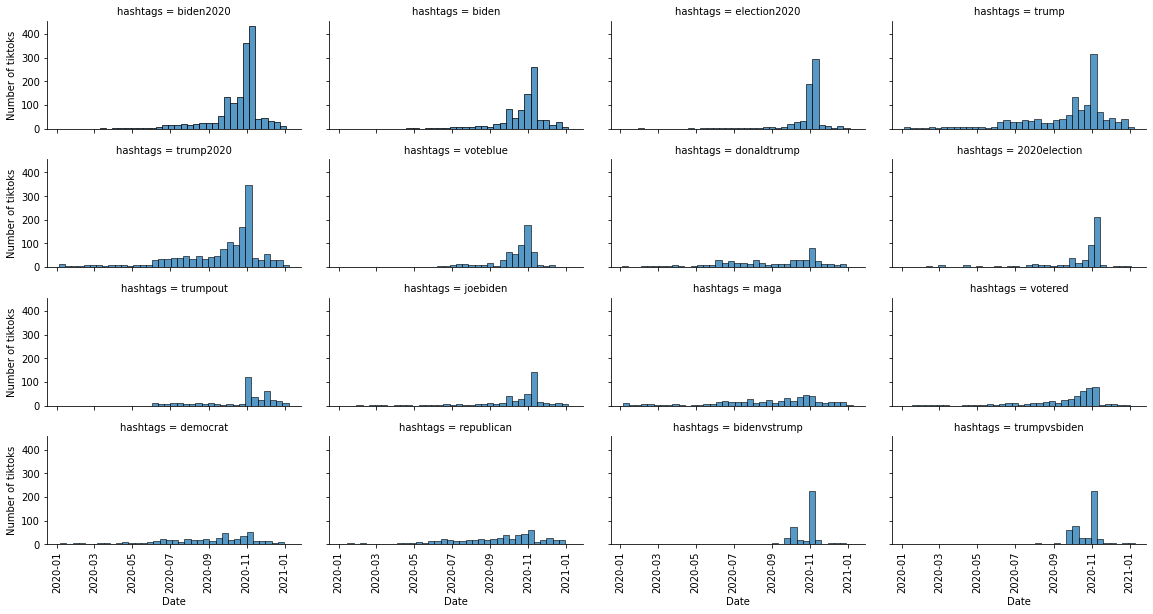

In [5]:
g = sns.FacetGrid(tiktoks_exploded.query("hashtags in @queried_hashtags"), col="hashtags", col_wrap = 4, sharex = True, sharey=True, height = 2, aspect=2)
g.map_dataframe(sns.histplot, x="date", binwidth=10)
g.set_axis_labels("Date", "Number of tiktoks")
g.set_xticklabels(rotation=90)

Display the top 20 most used hashtags in our dataset

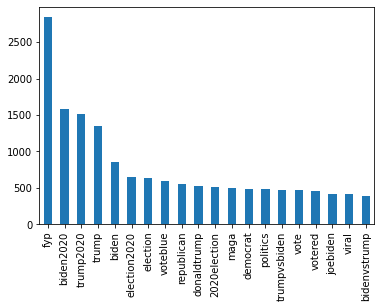

In [6]:
top_20 = tiktoks_exploded.hashtags.value_counts()[:20].plot(kind="bar")

# Looking at the distribution of hashtags overtime

Creating a new column to store only date of the video (to groupby videos based on date)

In [7]:
tiktoks_exploded['only_date'] = pd.to_datetime(tiktoks_exploded['date']).dt.date.astype(dtype='datetime64[ms]')

Grouping the tiktoks based on date and then hastags to the hashtag count perday

In [8]:
tiktoks_hash_grouped = tiktoks_exploded.groupby(["only_date","hashtags"]).size().to_frame(name = 'count').reset_index()
tiktoks_hash_grouped

,only_date,hashtags,count
0,2020-01-03,2020,1
1,2020-01-03,america,1
2,2020-01-03,arianagrande,1
3,2020-01-03,donaldtrump,1
4,2020-01-03,fyp,2
...,...,...,...
18351,2020-12-31,viratkohli,1
18352,2020-12-31,whatilearned,1
18353,2020-12-31,whatwouldyoudo,1
18354,2020-12-31,wordsofwisdom,1


As there are many hashtags that have occured very less frequent of time compared to others, we remove all the hashtags that have occured less than specified number of times

In [9]:
minimum_occurances = 100
hashtag_value_counts = tiktoks_hash_grouped["hashtags"].value_counts()
hash_list = hashtag_value_counts[hashtag_value_counts > minimum_occurances].index.tolist()

# hash_list contains the hashtags that have been used more than *minimum_occurances* number of times

In [10]:
tiktok_ht_min_occ = tiktoks_hash_grouped[tiktoks_hash_grouped['hashtags'].isin(hash_list)]

Creating a new dataframe with each hashtag as column and value as the count of hashtag occurance on that day

In [11]:
perday_hashtag_count = tiktok_ht_min_occ.pivot_table(values='count', index="only_date", columns='hashtags', aggfunc='first', fill_value=0)

In [12]:
plt.rcParams["figure.figsize"] = (10,30)

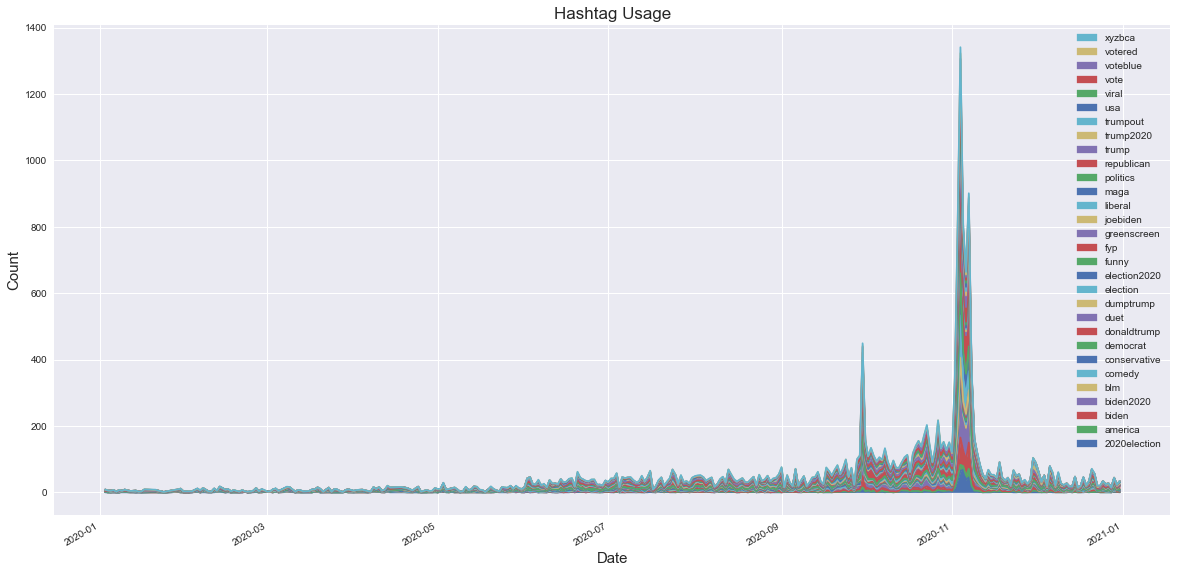

In [13]:
plt.style.use('seaborn')
perday_hashtag_count.plot.area(figsize=(20, 10))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Hashtag Usage', fontsize=17)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
ax.legend(handles, labels)
plt.show()

Similar plot using Seaborn

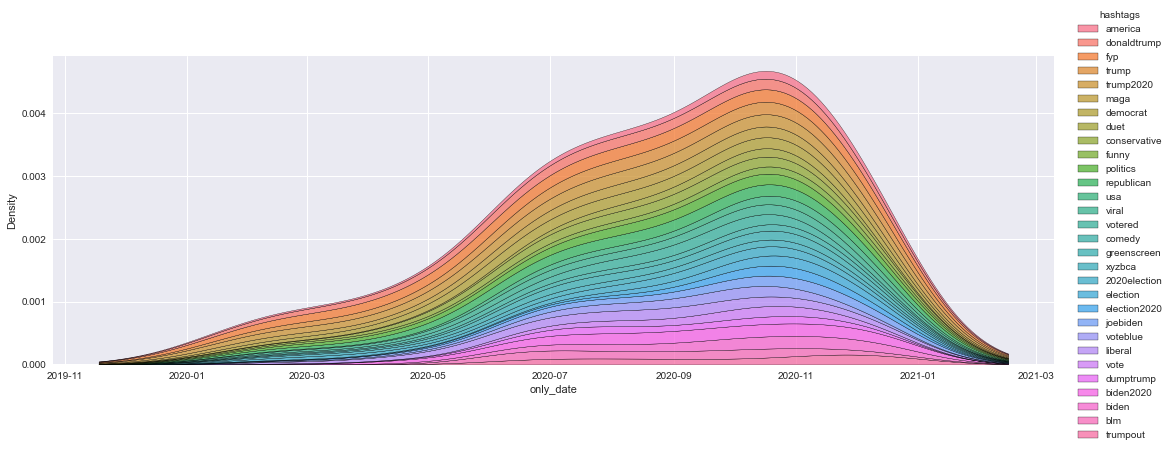

In [14]:
sns.displot(tiktok_ht_min_occ, x="only_date", hue="hashtags", kind="kde", multiple="stack", aspect = 3)

##### Using the area occupied by each hashtag in the plot we can how has the usage shifted over time

1. We should make small plots dividing over time to analyse easily

# Matching TikToks with events

Top 10 days when people posted tiktoks about the elections:

In [15]:
tiktoks["only_date"] = pd.to_datetime(tiktoks['date']).dt.date.astype(dtype='datetime64[ms]')
tiktoks.only_date.value_counts()[:10]

2020-11-04    395
2020-11-07    278
2020-11-05    260
2020-11-03    243
2020-11-06    201
2020-09-30    145
2020-11-08    127
2020-11-02    103
2020-10-27     58
2020-10-23     58
Name: only_date, dtype: int64

* Nov. 2-8 : Election Day was on the 3rd. With all the fuss about the count delays, recounts, fraud claims, etc... the hype lived up until the eighth
* Sep. 30 : The infamous first debate between Biden and Trump that ended up being a shitshow
* Oct. 27 : The Senate confirms Amy Coney Barrett to the supreme court one week before the election lol
* Oct. 23 : Second debate between Biden and Trump

# Cooccurances

Creates a co-occurance matrix using pandas

In [16]:
lst = list(tiktoks.hashtags)
u = (pd.get_dummies(pd.DataFrame(lst), prefix='', prefix_sep='')
       .groupby(level=0, axis=1)
       .sum())

v = u.T.dot(u)
v.values[(np.r_[:len(v)], ) * 2] = 0

In [17]:
def plot_co_occurance_matrix(matrix, threshold, figsize):
    fig, axes = plt.subplots(figsize=figsize)
    top_100_indices = matrix[matrix.sum(axis=1) > threshold].index
    print(len(top_100_indices))
    sns.heatmap(matrix[matrix.sum(axis=1) > threshold][list(top_100_indices)], cmap="rocket_r")

We plot the co_occurance matrix only using the hashtags with more than 600 occurances

* We observe that (biden, trump) and (biden2020, trump2020) have the most co-occurances. Could it suggest that most TikToks are about the elections in general and not rooting for a particular party ?
* Biden appears a lot with `fyp`, whereas Trump barely does. Does it show that Biden supporters are the more experienced TikTok's user and know that platform better ? Which would also show Biden supporters are the younger generation.
* Without surprise, (Trump, Trump2020) and (Biden, Biden2020) appear often together.
* blm doesn't seem more corrolated to biden than trump

## !"fyp" is not visible in the heatmap, not sure what is happening as it is present in top_100_indices.

49


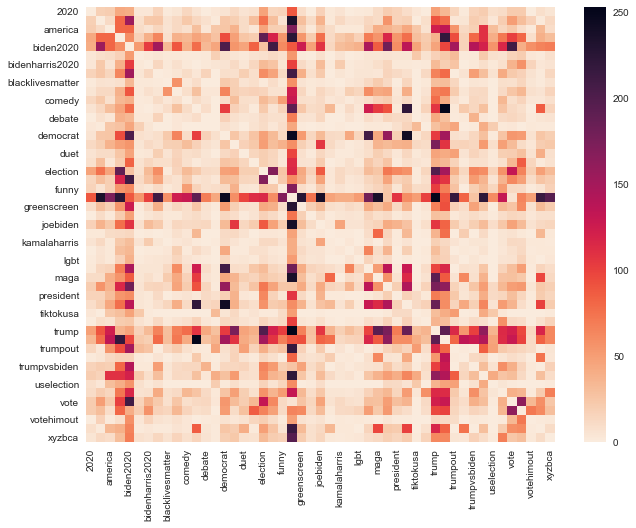

In [18]:
plot_co_occurance_matrix(v, 600, (10.5,8))

Let us now try to get a 2D embedding of each word from this co-occurance matrix by using the Truncated SVD from SkLearn

In [19]:
tsvd = TruncatedSVD(n_components=2)
v_transformed = tsvd.fit_transform(v)

We only keep the embeddings of the hashtags with more than 600 occurances

In [20]:
top_600_indices = list(v[v.sum(axis=1) > 600].index)
v_transformed_reduced = v_transformed[v.sum(axis=1) > 600]

Plot the embeddings

In [21]:
def plot_embeddings(words, vec, figsize):
    fig, axes = plt.subplots(figsize=(10,10))
    for i,word in enumerate(words):
        x = vec[i][0]
        y = vec[i][1]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y+0.01, word, fontsize=9)
    plt.show()

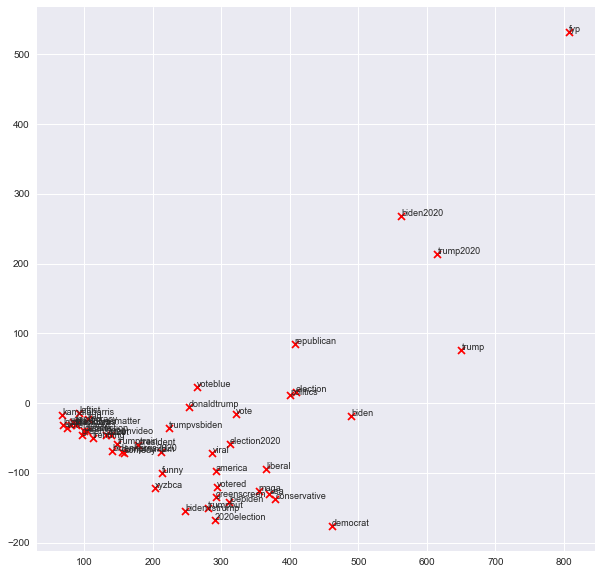

In [22]:
plot_embeddings(top_600_indices, v_transformed_reduced, (10,10))

**In the next cell, the parameter `vector_size` is just `size` in older version of gensim** 

In [23]:
model = Word2Vec(sentences=tiktoks.hashtags, vector_size=2, window=3, min_count=1, workers=4)
vecs = []
for hashtag in top_600_indices:
    vecs.append(model.wv[hashtag])

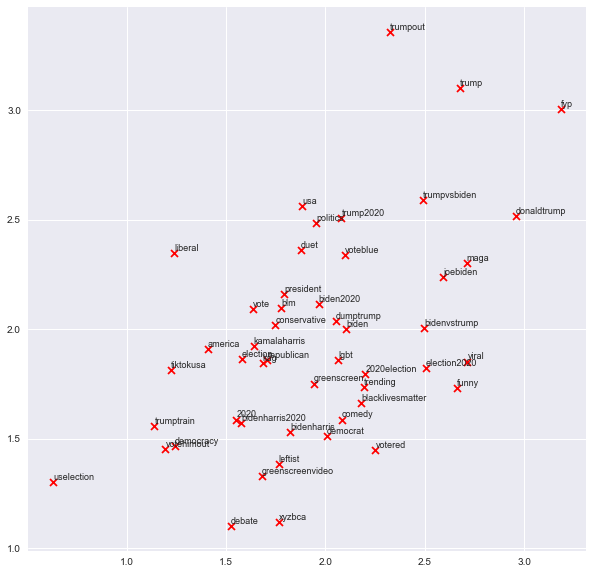

In [24]:
plot_embeddings(top_600_indices, vecs, (10,10))

Let's try to plot the heatmap of the word embeddings using the cosine similarity

In [25]:
vec_length = 10
model = Word2Vec(sentences=tiktoks.hashtags, vector_size=vec_length, window=2, min_count=1, workers=4)
vecs = np.empty((len(top_600_indices),vec_length))
for i in range(len(top_600_indices)):
    vecs[i] = model.wv[top_600_indices[i]]

## !The color map in the heatmap below is not intutive, (it has darkcolor for lower value and light color for highvalue). So we could change this

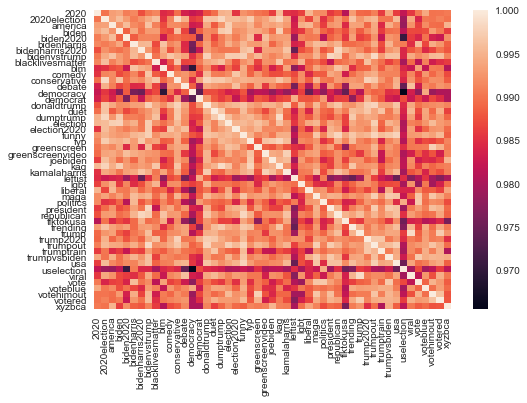

In [26]:
ax = sns.heatmap(cosine_similarity(vecs), xticklabels=top_600_indices, yticklabels=top_600_indices)

# User Clustering using hashtags

Create a user profile based on hashtags i.e create a bag of hashtag vector.

First, we select the hashtags with minimum occurances

# Video Clustering using hashtags

## Word Cloud of Hashtags

In [27]:
long_string = ','.join((list([a for b in tiktoks.hashtags.tolist() for a in b])))

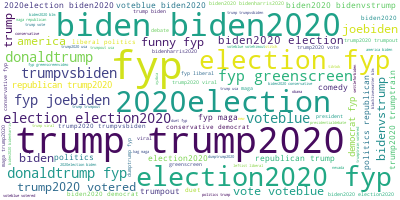

In [28]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### Word Cloud of Hashtags in USA map style.

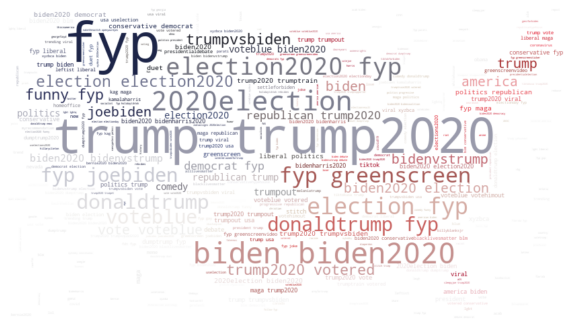

In [29]:
mask = np.array(Image.open("img/us.jpg"))
wordcloud_usa = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(long_string)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_usa.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

## Topic Modelling of videos

In [30]:
data_words = tiktoks.hashtags.values.tolist()

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

We shall remove those hashtags that have frequency less than the minimum frequency

In [31]:
ids = [id2word.token2id[hash_list[i]] for i in range(len(hash_list))]
id2word.filter_tokens(bad_ids=ids)

In [32]:
corpus = [id2word.doc2bow(text) for text in data_words]

In [33]:
scores = pd.DataFrame(columns=["c_v", "u_mass"])


for n_topics in range(2, 20, 1):
    print("Number of topics : ", n_topics)
    model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=n_topics)
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_model_lda_u_mass = CoherenceModel(model=model, corpus=corpus, dictionary=id2word, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_lda_u_mass = coherence_model_lda_u_mass.get_coherence() 
    print('Coherence Score c_v: ', coherence_lda)
    print('Coherence Score u_mass: ', coherence_lda_u_mass)
    scores.loc[n_topics] = {'c_v' : coherence_lda, 'u_mass': coherence_lda_u_mass}

Number of topics :  2
Coherence Score c_v:  0.5270934428650075
Coherence Score u_mass:  -10.859677579719902
Number of topics :  3
Coherence Score c_v:  0.5169841461730927
Coherence Score u_mass:  -11.10464489231257
Number of topics :  4
Coherence Score c_v:  0.5373887147050639
Coherence Score u_mass:  -12.39454896218308
Number of topics :  5
Coherence Score c_v:  0.5221842415690825
Coherence Score u_mass:  -12.117422142392542
Number of topics :  6
Coherence Score c_v:  0.560472871246088
Coherence Score u_mass:  -12.920310619649065
Number of topics :  7
Coherence Score c_v:  0.5415807518312526
Coherence Score u_mass:  -12.606792519233242
Number of topics :  8
Coherence Score c_v:  0.5140342099706628
Coherence Score u_mass:  -12.23011632751128
Number of topics :  9
Coherence Score c_v:  0.5356875172512723
Coherence Score u_mass:  -12.528436888406118
Number of topics :  10
Coherence Score c_v:  0.528206239363717
Coherence Score u_mass:  -12.376050918537379
Number of topics :  11
Coherence

In [34]:
copy_score = scores.copy()
copy_score = (copy_score-copy_score.mean())/copy_score.std()

Text(0, 0.5, 'Coherence Score (C_v)')

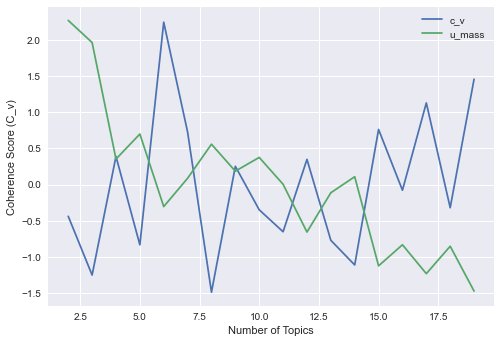

In [35]:
ax = copy_score.reset_index().plot(x = 'index', y = ['c_v', 'u_mass'], sharey=False)
ax.set_xlabel("Number of Topics")
ax.set_ylabel("Coherence Score (C_v)")

In [36]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.020*"president" + 0.013*"bidenharris2020" + 0.011*"debate" + '
  '0.011*"bidenvstrump" + 0.010*"2020" + 0.009*"progressive" + '
  '0.008*"presidentialdebate" + 0.008*"settleforbiden" + 0.007*"trumptrain" + '
  '0.007*"trumpvsbiden"'),
 (1,
  '0.013*"debate" + 0.012*"trumpvsbiden" + 0.010*"greenscreenvideo" + '
  '0.009*"trumptrain" + 0.008*"stitch" + 0.007*"meme" + '
  '0.007*"bidenharris2020" + 0.006*"bernie2020" + 0.006*"dumptrump2020" + '
  '0.006*"bidenvstrump"'),
 (2,
  '0.038*"trumpvsbiden" + 0.011*"2020" + 0.010*"bidenvstrump" + '
  '0.009*"president" + 0.009*"uselection" + 0.007*"debate" + '
  '0.006*"greenscreensticker" + 0.006*"greenscreenvideo" + 0.006*"trending" + '
  '0.006*"stitch"'),
 (3,
  '0.042*"trumpvsbiden" + 0.024*"bidenvstrump" + 0.013*"lgbt" + '
  '0.011*"trumptrain" + 0.010*"bidenharris2020" + 0.009*"greenscreenvideo" + '
  '0.009*"homeoffice" + 0.007*"blacklivesmatter" + 0.006*"2020" + '
  '0.006*"debate"'),
 (4,
  '0.029*"trumpvsbiden" + 0.015*"biden

In [37]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)


LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.048195  0.081733       1        1  12.840007
0      0.001232 -0.015578       2        1  10.811066
6      0.005970  0.115109       3        1  10.500151
2     -0.099983 -0.005647       4        1  10.270858
5      0.086439 -0.055285       5        1   9.704676
9     -0.013420 -0.088176       6        1   9.456410
4     -0.081059 -0.050140       7        1   9.265807
8      0.082935  0.032402       8        1   9.109778
7      0.027349 -0.009561       9        1   9.094172
1      0.038732 -0.004856      10        1   8.947075, topic_info=               Term        Freq       Total Category  logprob  loglift
425    trumpvsbiden  354.000000  354.000000  Default  30.0000  30.0000
708             kag   71.000000   71.000000  Default  29.0000  29.0000
49       votehimout   81.000000   81.000000  Default  28.0000  28.0000
711      trumptrain  113.000000  113.000000  Default  27.0000  27.0000
31           nevada   40.000000   40.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
113             gay    4.403639   36.650171  Topic10  -5.8409   0.2949
424    bidenvstrump    8.456375  293.605345  Topic10  -5.1884  -1.1335
241       president    5.845916  125.189067  Topic10  -5.5576  -0.6502
807  trumpsquad2020    4.402428   45.891272  Topic10  -5.8411   0.0697
105  settleforbiden    4.401833   52.751297  Topic10  -5.8413  -0.0697

[795 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
5029      1  0.660134                  134
2530     10  0.915238         2016election
50        1  0.128129                 2020
50        2  0.164738                 2020
50        3  0.027456                 2020
...     ...       ...                  ...
1219      6  0.910008                 zoom
4861      4  0.673838                 юмор
440       6  0.680191              セーラームーン
4016      8  0.898328  🇺🇸bidenharris2020🇺🇸
649       1  0.660124           🏳️\u200d⚧️

[1805 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 7, 3, 6, 10, 5, 9, 8, 2])

Trying to reproduce https://towardsdatascience.com/how-to-cluster-similar-sentences-using-tf-idf-and-graph-partitioning-in-python-5fb70627a4e0

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0)
tfidf = tf.fit_transform([' '.join(hs) for hs in data_words])

In [40]:
from sklearn.metrics.pairwise import linear_kernel
cs = linear_kernel(tfidf, tfidf)

In [41]:
import numpy as np
from tqdm import tnrange
top_n_sentences = []

no_dups = np.array([' '.join(hs) for hs in data_words])
i = 0
top_frame = []
for c, z in zip(cs, tnrange(len(cs))):
    # Create vector of titles
    start_name = pd.Series([no_dups[i]]*15) 
    # Index of top 15 similar titles
    ix_top_n = np.argsort(-c)[0:15]
    cos_sim = pd.Series(c[ix_top_n])
    names = pd.Series(no_dups[ix_top_n])
    i +=1
    top_frame.append(pd.DataFrame([start_name, names, cos_sim]).transpose())
    
top_frame = pd.concat(top_frame)
top_frame.columns = ['title1', 'title2', 'cos_sim']
# Remove the similarities for the same sentences
top_frame['is_same'] = [bool(i==j) for i, j in zip(top_frame['title1'], top_frame['title2'])]
top_frame = top_frame[top_frame['is_same'] != True]
        
top_n_sentences.append(top_frame)

  0%|          | 0/5232 [00:00<?, ?it/s]

In [42]:
top_n_sentences

[                                               title1  \
 1             aussie biden2020 bidenharris2020 straya   
 2             aussie biden2020 bidenharris2020 straya   
 3             aussie biden2020 bidenharris2020 straya   
 4             aussie biden2020 bidenharris2020 straya   
 5             aussie biden2020 bidenharris2020 straya   
 ..                                                ...   
 10  marineone patrioticparade trump votered walter...   
 11  marineone patrioticparade trump votered walter...   
 12  marineone patrioticparade trump votered walter...   
 13  marineone patrioticparade trump votered walter...   
 14  marineone patrioticparade trump votered walter...   
 
                                                title2   cos_sim  is_same  
 1   aussie bidenvstrump clubpositivityaustralia st...   0.19054    False  
 2   america aussie biden2020 bidenvstrump election...  0.186296    False  
 3        2020election biden biden2020 bidenharris2020  0.161323    False 

In [43]:
# We start by defining the structure of the graph
top_frame = top_n_sentences[0] #TDS articles
edges = list(zip(top_frame['title1'], top_frame['title2']))
weighted_edges = list(zip(top_frame['title1'], top_frame['title2'], top_frame['cos_sim']))
nodes = list(set(top_frame['title1']).union(set(top_frame['title2'])))

In [44]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
G.add_weighted_edges_from(weighted_edges)

In [45]:
partition = community.best_partition(G)
modularity = community.modularity(partition, G)

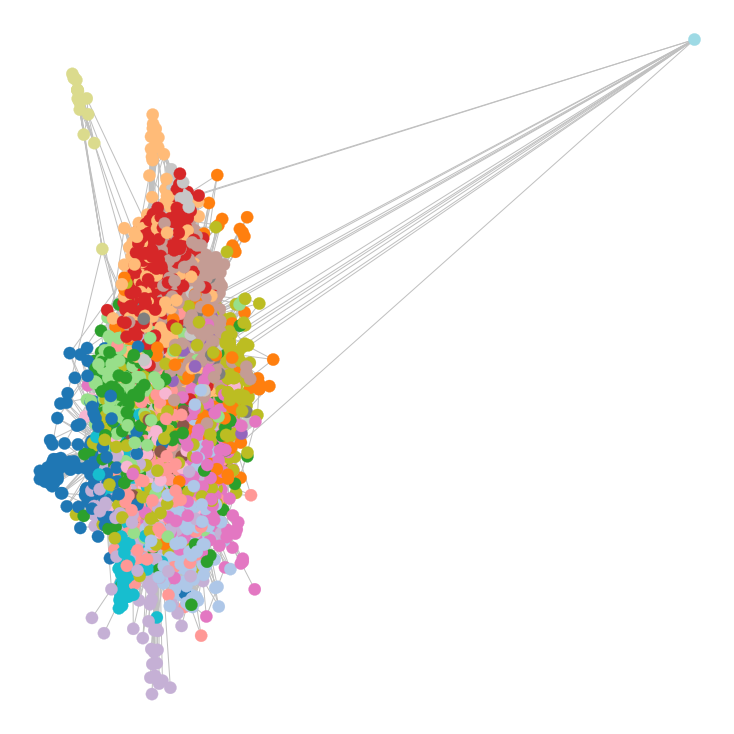

In [46]:
# Takes some time for larger graphs

pos = nx.spring_layout(G, dim=2)
community_id = [partition[node] for node in G.nodes()]
fig = plt.figure(figsize=(10,10))
nx.draw(G, pos, edge_color = ['silver']*len(G.edges()), cmap=plt.cm.tab20,
        node_color=community_id, node_size=150)

In [47]:
title, cluster = [], []
for i in partition.items():
    title.append(i[0])
    cluster.append(i[1])
    
frame_clust = pd.DataFrame([pd.Series(title), pd.Series(cluster)]).transpose()
frame_clust.columns = ['Title', 'Cluster']

In [48]:
frame_clust.groupby('Cluster').count()

,Title
Cluster,
0,257
1,241
2,245
3,228
4,479
5,299
6,491
7,356
8,51


In [49]:
def find_n_top_words(topic):

    frame_clust['Title'] = frame_clust.apply(lambda row: " " + row['Title'] , axis=1)
    wordstring = frame_clust[frame_clust['Cluster']==topic]['Title'].str.cat()
    wordlist = wordstring.split(' ')
    wordfreq = [wordlist.count(w) for w in wordlist]


    pairs = [p for p in set(zip(wordlist, wordfreq)) if p[0]!='']
    top_n_words = sorted(pairs, key=lambda tup: tup[1], reverse=True)[:10]
    top_n_words = [w[0] for w in top_n_words]
    print("===== TOPIC ", topic)
    print(top_n_words)
    print("")
    return top_n_words

In [50]:
for i in range(21):
    find_n_top_words(i)

===== TOPIC  0
['2020election', 'fyp', 'biden2020', 'trump2020', 'election', 'trump', 'vote', 'politics', 'biden', 'greenscreenvideo']

===== TOPIC  1
['trumpout', 'fyp', 'duet', 'biden2020', 'trump', 'billyblanksjr', 'election', 'biden', 'viral', 'bidenharris2020']

===== TOPIC  2
['fyp', 'trump2020', 'biden2020', 'greenscreen', 'voteblue', 'gay', 'lgbtq', 'lgbt', 'trumpvsbiden', 'trump']

===== TOPIC  3
['maga', 'trump2020', 'fyp', 'blm', 'trump', 'blacklivesmatter', 'votered', 'biden2020', 'duet', 'kag']

===== TOPIC  4
['fyp', 'trump', 'trumpvsbiden', 'biden', 'biden2020', 'trump2020', 'viral', 'debate', 'funny', 'politics']

===== TOPIC  5
['bidenvstrump', 'fyp', 'biden2020', 'biden', 'trump', 'trump2020', 'election', 'trumpvsbiden', 'duet', 'greenscreen']

===== TOPIC  6
['trump2020', 'votered', 'fyp', 'trump', 'maga', 'republican', 'trumptrain', 'conservative', 'america', 'biden']

===== TOPIC  7
['election2020', 'fyp', 'biden2020', 'election', 'trump2020', 'trumpvsbiden', 'trum

## Hashtag Analysis

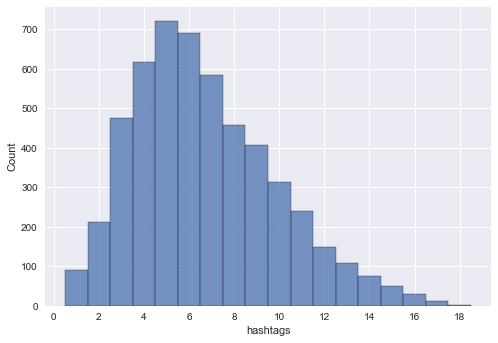

In [51]:
tiktoks_hashtag_count = tiktoks.hashtags.apply(lambda x: len(x))
ax = sns.histplot(tiktoks_hashtag_count, discrete=True)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

From the histogram above, we obtain an insight into the number of hashtags used per video. On average users use 5,6,7 hashtags per video and only few videos use more than 10 hashtags.

Next we build a graph of hashtags where each none of the craft represents a hashtag and an edge between two loads exist if the hashtags are mentioned together

In [52]:
hashtag_graph = nx.Graph()

for hashtag_list in data_words:
    if len(hashtag_list) == 1:
        if (hashtag_list[0] in hash_list):
            hashtag_graph.add_node(hashtag_list[0])
    else:
        links = list(combinations(hashtag_list, 2))
        
        for ht1, ht2 in links:
            if (ht1 in hash_list) and (ht2 in hash_list):
                hashtag_graph.add_edge(ht1, ht2)

In [53]:
nodes_df = pd.DataFrame(hashtag_graph.nodes()).rename(columns={0:"hashtag"})

In [54]:
hashtag_betweeness = nx.betweenness_centrality(hashtag_graph)
nodes_df['betweeness_centrality'] = nodes_df['hashtag'].map(lambda x: hashtag_betweeness[x])

In [55]:
hashtag_clustering_coeff = nx.clustering(hashtag_graph)
nodes_df['clustering_coefficient'] = nodes_df['hashtag'].map(lambda x: hashtag_clustering_coeff[x])

In [56]:
hashtag_adjacencies = dict(hashtag_graph.adjacency())
nodes_df['adjacency_frequency'] = nodes_df['hashtag'].map(lambda x: len(hashtag_adjacencies[x]))

In [57]:
communities = greedy_modularity_communities(hashtag_graph)

In [58]:
communities_dict = {}

nodes_in_community = [list(i) for i in communities]

for i in nodes_in_community:
    communities_dict[nodes_in_community.index(i)] = i

def community_allocation(source_val):
    for k,v in communities_dict.items():
        if source_val in v:
            return k

nodes_df['community'] = nodes_df['hashtag'].map(lambda x: community_allocation(x))

In [59]:
nodes_df

,hashtag,betweeness_centrality,clustering_coefficient,adjacency_frequency,community
0,biden,0.000182,0.995074,29,0
1,biden2020,0.000182,0.995074,29,0
2,election2020,0.000182,0.995074,29,0
3,fyp,0.000182,0.995074,29,0
4,viral,0.000182,0.995074,29,0
5,trump,0.000182,0.995074,29,0
6,trump2020,0.000182,0.995074,29,0
7,blm,0.000182,0.995074,29,0
8,comedy,0.000182,0.995074,29,0
9,greenscreen,0.000182,0.995074,29,0
